In [1]:
import stim
import numpy as np
import qiskit
import itertools
import nbimporter

from NonCliff_1Meas_V4 import *
from stab_rank_approx import *

from qiskit.quantum_info import Pauli, PauliList, StabilizerState
from typing import List, Tuple

In [2]:
def find_nearest_neighbors_general_V2(num_qubits: int, stab_state: np.array) -> List:
    """ 
    Construct list of all nearest neighbor stabilizer states for arbitrary stabilizer state.

    Parameters:
    -----------
    stab_state - Stabilizer state for which we wish to find neighbors

    Returns:
    --------
    List of nearest neighbors
    """
    bias = 1/np.sqrt(2)
    all_paulis = generate_all_paulis(num_qubits)
    new_stabs = [p.to_matrix() @ stab_state for p in all_paulis]
    new_stabs_orthogonal = [stab for stab in new_stabs if np.vdot(stab_state, stab) == 0]
    neighbors = [np.add(stab_state, stab) * bias for stab in new_stabs_orthogonal]
    neighbors_dict = {stab.tobytes(): stab for stab in neighbors}
    # return list(neighbors_dict.values())
    final_neighbors = list(neighbors_dict.values())
    final_neighbors.append(stab_state)
    return final_neighbors

In [3]:
def is_orthogonal(used_states: List, curr_stab: np.array):
    """
    Checks that all the stabilizer states that are being used for decomposition are indeed orthogonal

    Params:
    -------
    used_states - stabilizer states used so far 
    curr_stab - Next stabilizer state to be used for decomposition
    """ 
    if (np.array_equal(curr_stab, None)):
        return False
    for elem in used_states:
        if (np.vdot(curr_stab, elem) != 0):
            return False 
    return True 

def iterated_optimal_nearest_neighbor_V2(num_qubits:int, eig_vec:np.array, init_stab_state: np.array, used_states: List) -> np.array:
    """ 
    Iteratively compute the optimal nearest neighbor whose inner product with 'eig_vec' is maximal

    Parameters:
    -----------
    num_qubits - Number of qubits
    eig_vec - Eigenvector we wish to approximate
    init_stab_state - Initial stabilizer state where we start our search from 

    Returns:
    --------
    Optimal single state that best approximates 'eig_vec'
    """
    num_iterations = 2 ** num_qubits
    curr_stab_state = init_stab_state
    max_inner_prod = 0
    curr_best_stab_state = None
    for _ in range(num_iterations):
        curr_neighbors = find_nearest_neighbors_general_V2(num_qubits, curr_stab_state)
        if (used_states != []):
            cp = []
            for neighbor in curr_neighbors:
                for state in used_states:
                    if (np.vdot(neighbor, state) == 0):
                        cp.append(neighbor)
            curr_neighbors = cp
        optimal_neighbor = curr_neighbors[np.argmax([np.abs(np.vdot(neighbor, eig_vec)) for neighbor in curr_neighbors])]
        curr_stab_state = optimal_neighbor 
        #curr_inner_prod = np.vdot(curr_stab_state, eig_vec)
        curr_inner_prod = np.abs(np.vdot(curr_stab_state, eig_vec))
        if (np.array_equal(curr_best_stab_state,curr_stab_state)):
            break
        if (curr_inner_prod > max_inner_prod):
            max_inner_prod = curr_inner_prod 
            curr_best_stab_state = curr_stab_state

    return curr_best_stab_state, max_inner_prod

In [4]:
def one_state_stab_approx_V2(num_qubits:int, eig_vec: np.array, used_states: List) -> np.array:
    """ 
    Find best (?) single stabilizer state approximation for eigen vector 

    Parameters:
    -----------
    num_qubits - Number of qubits
    eig_vec - Eigenvector we wish to approximate

    Returns:
    --------
    Best (?) single stabilizer state that approximates eigenvector
    """

    basis_vecs = comp_base_vecs(num_qubits) # Basis vectors given number of qubits
    init_state = eig_vec.copy() # Make a copy of the original eigenvector
    #final_approx_state = np.zeros((2**num_qubits,), dtype=complex) # Where result for best stab state approx is stored
    
    # Find basis state with maximum coefficient
    max_coeff = state_max_coeff(eig_vec, basis_vecs)
    init_stab_state = basis_vecs[max_coeff]

    # Compute optimal nearest stab state in iterated fashion
    final_approx_state, max_inner_prod = iterated_optimal_nearest_neighbor_V2(num_qubits, eig_vec, init_stab_state, used_states)

    return final_approx_state, max_inner_prod

Will need to try a Brute-Force approach to search all possible stabilizer states to find the optimal stabilizer rank decomposition:
FIRST LOOK AT SPARSIFICATION LEMMA

In [5]:
def stab_rank_approx_four_V2(num_qubits: int, eig_vec: np.array) -> Tuple:
    """ 
    Approximate the stabilizer rank (using approach discussed)

    Parameters:
    -----------
    num_qubits - Number of qubits
    eig_vec - Eigenvector for which we'd like to evaluate stabilizer rank

    Returns:
    --------
    Approximate stabilizer rank for eigenvector
    """
    approx_stab_rank = 0 
    approx_vec = np.zeros(len(min_eigvec), dtype=complex) # Vector we wish to construct to approximate 'eig_vec'
    approx_coeff_state = []
    prec_param = 0.02 # Precision parameter to see how close dot prod of 'approx_vec' and 'eig_vec' is
    used_states = []
    norm_factor = 0
    last_inner = 0
    is_approx = False # While loop termination condition

    copy_vec = eig_vec.copy()
    while (is_approx == False):
        # Calculate nearest stabilizer state
        s, s_inner_prod = one_state_stab_approx_V2(num_qubits, eig_vec, used_states)
        #print("Is orthogonal?: " + str(is_orthogonal(used_states, s)))
        #used_states.append(s)
        #print("Stab: " + str(list(s)))

        # Project 'eig_vec' on s
        s_norm = np.linalg.norm(s)
        s_coeff = np.vdot(s, eig_vec)
        if (norm_factor == 0):
            proj_vec = (s_coeff) * s
            approx_coeff_state.append((s_coeff, s))
        else:
            proj_vec = norm_factor * (s_coeff) * s
            approx_coeff_state.append((s_coeff * norm_factor, s))

        # Subtract projection of 'eig_vec' on s from 'eig_vec'
        unnorm_eig_vec = eig_vec - proj_vec 
        norm_factor = np.linalg.norm(unnorm_eig_vec)
        #eig_vec = unnorm_eig_vec / norm_factor
        eig_vec = unnorm_eig_vec

        # Add projection to approximation and update stab rank
        approx_vec += proj_vec
        approx_stab_rank += 1

        # Check closeness of approximation to original 'eig_vec'

        """ 
        if (last_inner > np.vdot(approx_vec / np.linalg.norm(approx_vec), copy_vec)):
            approx_vec -= proj_vec
            approx_stab_rank -= 1
            break
        """

        last_inner = np.vdot(approx_vec, copy_vec)
        norm_dist = np.linalg.norm(copy_vec - approx_vec)
        print("How close (inner_prod): " + str(last_inner))
        print("How close (norm_dist): " + str(norm_dist))
        if (np.abs(1 - np.vdot(approx_vec, copy_vec)) <= prec_param):
            is_approx = True 

        #if (approx_stab_rank == 2 ** num_qubits):
        #    break

        #print("Approx vec so far: " + str(list(approx_vec)))
        
    approx_vec = approx_vec / np.linalg.norm(approx_vec)
    
    return approx_stab_rank, approx_vec, approx_coeff_state


In [41]:
rng = np.random.default_rng()
t = np.array([[1,2,3],[4,5,6],[7,8,9]])
rng.choice(a=t, size=2, p=[0.0,1.0,0.0])

array([[4, 5, 6],
       [4, 5, 6]])

### Applying Sparsification Lemma From https://arxiv.org/abs/1808.00128

In [54]:
def sparsify_stab_decomp(approx_vec: List, delta: float) -> Tuple: 
    """ 
    Apply Sparsification Lemma to 'approx_vec'
    """
    # Separate coefficients and vectors
    coeffs = [np.abs(elem[0]) for elem in approx_vec]
    vecs = [elem[1] for elem in approx_vec]
    rng = np.random.default_rng()

    # Define c_1
    c_1 = sum(coeffs)

    # Determine desired stabilizer rank
    chi = int(np.rint(np.power(delta, -2) * np.power(c_1, 2)))

    # Choose vectors to form approximate stab decomp
    print(np.shape(vecs))
    print(chi)
    print(np.shape(coeffs/(np.sum(coeffs))))
    approx_stab_decomp_vecs = rng.choice(a=vecs, size=chi, p=coeffs/(np.sum(coeffs)))

    # Form new stab decomp
    approx_stab_decomp = np.zeros((chi,))
    approx_coeff_vec_list = []
    norm_factor = 1/np.sqrt(chi)
    for vec in approx_stab_decomp_vecs:
        approx_stab_decomp += norm_factor * vec 

    return approx_stab_decomp





In [7]:
num_wit_qubits = 20 # variable 'n' in paper
# For now, what the witness qubits are initialized to be doesn't matter (I THINK)
# as we are trying to minimize Val, given some optimal input states.
wit_qubits = np.zeros(num_wit_qubits, dtype=complex)

num_anc_qubits = 0 # variable 'm' in paper
anc_qubits = np.zeros(num_anc_qubits, dtype=complex)

num_t_gates = 4 # variable 't' in paper

num_meas_qubits = 1 # variable 'k' in paper
total_qubits = num_wit_qubits + num_anc_qubits

num_layers = 100

assert(num_layers > 0)

In [8]:
p_sum, _ = sim_circ(total_qubits, num_layers, num_t_gates)
succinct_p_sum, succinct_basis = p_sum.succinct_p_sum(total_qubits)
succinct_p_sum.set_bases(succinct_basis)
min_eigvec = succinct_p_sum.compute_min_eig_eigvec(len(p_sum.get_bases()))[1]
new_total_qubits = len(succinct_p_sum.get_sum()[0].get_pauli_str(succinct_p_sum.get_sum()[0].get_pauli()))
print(succinct_p_sum)
print(list(min_eigvec))

[(-0.4999999999999999+0j) ZIII] + [(0.4999999999999999-0j) XZII] + [(0.3535533905932737-0j) YIZI] + [(-0.4999999999999999+0j) XXXZ] + [(-0.3535533905932737+0j) IXYZ]
[(0.012062168986335763-0.0010999624854878725j), (0.09656719686509034+0.0019818963392177827j), (0.29406492648397486-0.03667131155998507j), (0.19585222759597326-0.027613564587386716j), (0.5332327133033258+0j), (-0.09253898841924638+0.12181986885053805j), (-0.08033964232535329-0.0858399453097737j), (0.3343087020363136-0.3965486309284023j), (-0.044845226618014655-0.03228802131595409j), (-0.13809107910098523+0.15826272829145624j), (0.12798139405011727+0.15515383726011855j), (-0.011697366221551892+0.03245410023471585j), (0.31233599008034824-0.16807343022860485j), (-0.07506669167367457+0.0688656975653452j), (0.005083870969937544-0.05848632584235541j), (0.2100174598516369-0.021497812864798474j)]


In [9]:
approx_stab_rank, approx_vec, approx_coeff_state = stab_rank_approx_four_V2(new_total_qubits, min_eigvec)
print(approx_stab_rank, approx_vec, approx_coeff_state)

How close (inner_prod): (0.5688360608079408+2.7755575615628914e-17j)
How close (norm_dist): 0.6566307479794554
How close (inner_prod): (0.7032852353753357+0.07827488279501651j)
How close (norm_dist): 0.5045918814666153
How close (inner_prod): (0.7825739175654292+0.07578362705274158j)
How close (norm_dist): 0.3946561412306416
How close (inner_prod): (0.8492731607552111+0.05286085097126303j)
How close (norm_dist): 0.3273710059702479
How close (inner_prod): (0.8591079427405708+0.04229997764279242j)
How close (norm_dist): 0.2854582094660131
How close (inner_prod): (0.8773717007494042+0.04629570969082111j)
How close (norm_dist): 0.25554486502657203
How close (inner_prod): (0.9017087172447631+0.041540000134103944j)
How close (norm_dist): 0.22883773313119962
How close (inner_prod): (0.9116588029473366+0.04317710869037217j)
How close (norm_dist): 0.20613175454934696
How close (inner_prod): (0.9221150126421596+0.038809602981732416j)
How close (norm_dist): 0.18856605285558056
How close (inner_pr

### Calculating Stabilizer Rank for Range of T-Gates

In [22]:
num_iter = 50
stab_rank_avg = 0
num_t_gates = 0
t_gate_cap = 5
stab_rank_list = []
for _ in range(t_gate_cap):
    stab_rank_avg = 0
    for i in range(num_iter):
        print(i)
        p_sum, _ = sim_circ(total_qubits, num_layers, num_t_gates)
        succinct_p_sum, succinct_basis = p_sum.succinct_p_sum(total_qubits)
        succinct_p_sum.set_bases(succinct_basis)
        min_eigvec = succinct_p_sum.compute_min_eig_eigvec(len(p_sum.get_bases()))[1]
        new_total_qubits = len(succinct_p_sum.get_sum()[0].get_pauli_str(succinct_p_sum.get_sum()[0].get_pauli()))
        approx_stab_rank, _, _ = stab_rank_approx_four_V2(new_total_qubits, min_eigvec)
        stab_rank_avg += approx_stab_rank
    stab_rank_avg = stab_rank_avg / num_iter
    print(stab_rank_avg)
    stab_rank_list.append((num_t_gates, stab_rank_avg))
    num_t_gates += 1

0
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
1
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
2
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
3
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
4
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
5
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
6
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
7
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
8
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
9
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
10
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
11
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
12
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
13
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
14
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
15
How close (inner_prod): (1+0j)
How close (norm_dist): 0.0
16
How close (inner_prod): (1+0j)


In [23]:
print(stab_rank_list)

[(0, 1.0), (1, 8.8), (2, 13.22), (3, 18.86), (4, 31.28)]


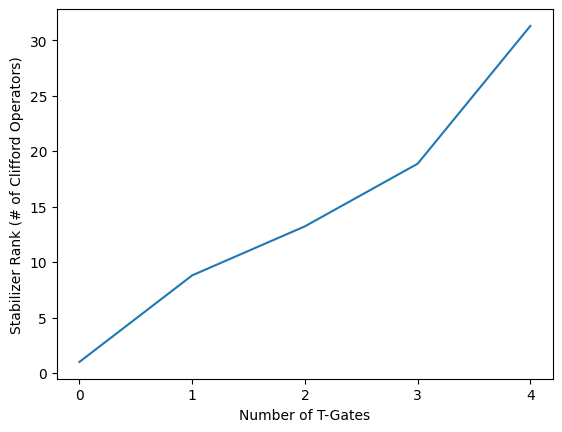

In [24]:
%matplotlib inline 
import matplotlib.pyplot as plt
x = [s[0] for s in stab_rank_list]
y = [s[1] for s in stab_rank_list]
# Exponential Fit
exp_fit = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
exp_x = np.array(x) 
exp_y = np.exp(exp_fit[1]) * np.exp(exp_fit[1] * exp_x)
plt.xticks(x)
plt.plot(x,y)
#plt.plot(exp_x, exp_y)
plt.xlabel("Number of T-Gates")
plt.ylabel("Stabilizer Rank (# of Clifford Operators)")
plt.show()